In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

In [17]:
data=pd.read_csv('data/headstart.csv')
len_before=len(data.index)
data=data.dropna(how='any',subset=['povrate60','mort_age59_related_postHS','census1960_pop'])
len_after=len(data.index)
print('Dropped',len_before-len_after,'lines that contain NaN.')

Dropped 26 lines that contain NaN.


In [92]:
# t is the threshold, k is a kernel function [0,1]->R, and b is the bandwidth
# Currently supports only 1D array
def regr_symmetric(X,Y,t,k,b):
    # Dispose points outside bandwidth
    XL=X[np.logical_and(t-b<X,X<t)]
    YL=Y[np.logical_and(t-b<X,X<t)]
    XR=X[np.logical_and(t<X,X<t+b)]
    YR=Y[np.logical_and(t<X,X<t+b)]
    
    # Calculate weights    
    get_weight=np.vectorize(lambda x:k(np.abs((x-threshold))/b))
    WL=get_weight(XL)
    WR=get_weight(XR)
    
    # Print weight
    print('Weights:')
    y=np.linspace(0,k(0),1000)
    x=t+0*y
    plt.plot(x,y,color='blue',linewidth=1)
    plt.plot(XL, get_weight(XL), color='purple', linewidth=2)
    plt.plot(XR, get_weight(XR), color='purple', linewidth=2)
    plt.show()
    
    # Reshape for lib use
    # Every data has a single feature
    XL=XL.values.reshape(-1,1)
    YL=YL.values.reshape(-1,1)
    XR=XR.values.reshape(-1,1)
    YR=YR.values.reshape(-1,1)
    
    # Create linear regression object
    regrL = linear_model.LinearRegression()
    regrR = linear_model.LinearRegression()
    
    # Train the model using the training sets
    regrL.fit(XL, YL, sample_weight=WL)
    regrR.fit(XR, YR, sample_weight=WR)
    
    # Make predictions using the testing set
    YL_pred = regrL.predict(XL)
    YR_pred = regrR.predict(XR)
    EY_L = regrL.predict([[t]])[0][0]
    EY_R = regrR.predict([[t]])[0][0]
    
    # Output
    plt.scatter(XL, YL, s=0.2, color='black')
    plt.plot(XL, YL_pred, color='red', linewidth=2)
    plt.scatter(XR, YR, s=0.2, color='black')
    plt.plot(XR, YR_pred, color='red', linewidth=2)
    # Plot separating line
    y=np.linspace(0,max(EY_L,EY_R),1000)
    x=t+0*y
    plt.plot(x,y,color='blue',linewidth=1)
    plt.show()
    print('E[Y-]',EY_L)
    print('E[Y+]',EY_R)
    print('Estimated effect',EY_R-EY_L)
    
    return (regrL,regrR)

Weights:


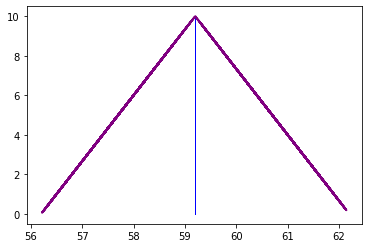

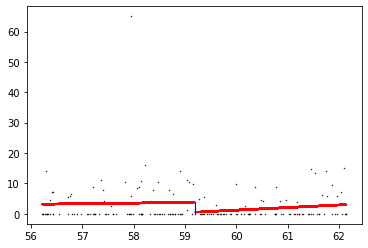

E[Y-] 3.7359632960497464
E[Y+] 0.49151239614238307
Estimated effect -3.2444508999073634


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

In [97]:
threshold=59.1984
def ker_tri(x):
    return 10*(1-x)# Note that the constant 10 here will not affect the result
regr_symmetric(data['povrate60'],
               data['mort_age59_related_postHS'],
               threshold,
               (lambda x:10*(1-x)),
               3)

Weights:


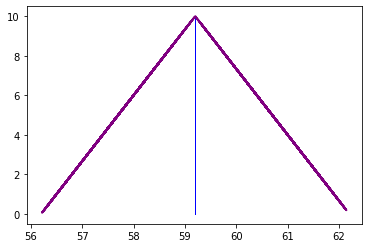

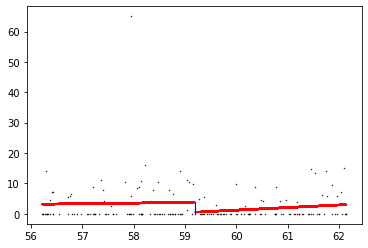

E[Y-] 3.7359632960497464
E[Y+] 0.49151239614238307
Estimated effect -3.2444508999073634


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

In [94]:
threshold=59.1984
def ker_tri(x):
    return 5*(1-x)
regr_symmetric(data['povrate60'],
               data['mort_age59_related_postHS'],
               threshold,
               (lambda x:10*(1-x)),
               3)